In [9]:
# --- IMPORT MEDIAPIPE LÊN ĐẦU TIÊN ---
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import Image as MpImage

import cv2 # Thư viện này thường gây xung đột
import numpy as np
import pandas as pd
import os
import time
from scipy.spatial import distance as dist #Sử dụng spicy để tính các CT Euclidean

NameError: name 'audio_classifier' is not defined

In [ ]:
#--- HẰNG SỐ CƠ BẢN ---
DATA_ROOT = "./Datasets_train"
OUTPUT_DIR = "./Outputs" # Output Directory
OUTPUT_CSV = os.path.join(OUTPUT_DIR, 'training-feature.csv')
DUMMY_VALUE = -999.0 # Giá trị Dummy / Place holder khi dữ liệu không tin cậy

In [ ]:
#--- Geometric head-pose (replacement for solvePnP) ---
import math

def calculate_geometric_head_pose(landmarks, w, h, overlay=None):
    """Calculate head pose (pitch, yaw, roll) using 2D geometric heuristics and draw diagnostics on overlay if provided."""
    try:
        nose = landmarks[1]
        left_eye_outer = landmarks[33]
        right_eye_outer = landmarks[263]
        mouth_center = landmarks[13] # Upper lip center roughly

        nx, ny = float(nose.x) * w, float(nose.y) * h
        lx, ly = float(left_eye_outer.x) * w, float(left_eye_outer.y) * h
        rx, ry = float(right_eye_outer.x) * w, float(right_eye_outer.y) * h
        mx, my = float(mouth_center.x) * w, float(mouth_center.y) * h

        # draw eye-to-eye line for roll visualization
        try:
            if overlay is not None:
                cv2.line(overlay, (int(lx), int(ly)), (int(rx), int(ry)), (255, 0, 255), 2)
        except Exception:
            pass

        # ROLL: eye-line angle
        dY = ry - ly
        dX = rx - lx + 1e-6
        roll = math.degrees(math.atan2(dY, dX))

        # YAW: asymmetry of nose distance to left/right eye
        dist_l = math.hypot(nx - lx, ny - ly)
        dist_r = math.hypot(nx - rx, ny - ry)
        yaw = ((dist_l - dist_r) / (dist_l + dist_r + 1e-6)) * 150.0

        # PITCH: relative nose distance to eye midpoint vs nose->mouth distance
        ex, ey = (lx + rx) / 2.0, (ly + ry) / 2.0
        dist_nose_eyes = math.hypot(nx - ex, ny - ey)
        dist_nose_mouth = math.hypot(nx - mx, ny - my) + 1e-6
        pitch = (dist_nose_eyes / dist_nose_mouth - 1.0) * 100.0

        # # clamp
        # yaw = max(min(yaw, 180.0), -180.0)
        # pitch = max(min(pitch, 180.0), -180.0)
        # roll = max(min(roll, 180.0), -180.0)

        return pitch, yaw, roll
    except Exception:
        return DUMMY_VALUE, DUMMY_VALUE, DUMMY_VALUE


def get_head_pose(landmarks_list, w, h, overlay=None):
    """Compatibility wrapper: returns ((yaw, pitch, roll), None) like original API expected."""
    try:
        pitch, yaw, roll = calculate_geometric_head_pose(landmarks_list, w, h, overlay)
        return (yaw, pitch, roll), None
    except Exception:
        return (DUMMY_VALUE, DUMMY_VALUE, DUMMY_VALUE), None

In [ ]:
# --- Debug: print head-pose (yaw/pitch/roll) for up to 5 sample images ---
# This cell will attempt to initialize MediaPipe landmarkers if the .task files exist.
# If not present it will list up to 5 sample image paths for manual inspection.
import os

face_model_path = os.path.join('model', 'face_landmarker.task')
pose_model_path = os.path.join('model', 'pose_landmarker_full.task')

# collect up to 5 image paths from DATA_ROOT
sample_paths = []
for d in sorted(os.listdir(DATA_ROOT)):
    dd = os.path.join(DATA_ROOT, d)
    if not os.path.isdir(dd):
        continue
    for f in sorted(os.listdir(dd)):
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            sample_paths.append(os.path.join(dd, f))
        if len(sample_paths) >= 5:
            break
    if len(sample_paths) >= 5:
        break

print('Sample images found:', len(sample_paths))
for p in sample_paths:
    print(' -', p)

if not (os.path.exists(face_model_path) and os.path.exists(pose_model_path)):
    print('\nMediaPipe .task files not found; cannot compute head-pose.\nPlace face_landmarker.task and pose_landmarker_full.task in ./model/ and re-run this cell to compute yaw/pitch/roll.')
else:
    try:
        base_options_face = python.BaseOptions(model_asset_path=face_model_path)
        face_options = vision.FaceLandmarkerOptions(base_options=base_options_face, running_mode=vision.RunningMode.IMAGE)
        face_landmarker = vision.FaceLandmarker.create_from_options(face_options)
    except Exception as e:
        print('Failed to initialize face landmarker:', e)
        face_landmarker = None

    if face_landmarker is None:
        print('Face landmarker not available; aborting head-pose debug.')
    else:
        import cv2
        for p in sample_paths:
            img = cv2.imread(p)
            if img is None:
                print('Failed to read', p)
                continue
            h, w = img.shape[:2]
            try:
                rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                mp_img = MpImage(image_format=mp.ImageFormat.SRGB, data=rgb)
                fres = face_landmarker.detect(mp_img)
                fl = getattr(fres, 'face_landmarks', None)
                if not fl or len(fl) == 0:
                    print(p, '-> no face detected')
                    continue
                landmarks = fl[0]
                (yaw, pitch, roll), _ = get_head_pose(landmarks, w, h)
                print(p, '-> yaw={:.2f}, pitch={:.2f}, roll={:.2f}'.format(yaw, pitch, roll))
            except Exception as e:
                print('Error processing', p, ':', e)

Sample images found: 5
 - ./Datasets_train\Awake\100_jpg.rf.c81efb146d155327305f5470bfc60b6d.jpg
 - ./Datasets_train\Awake\101_jpg.rf.84809ab52d0cf4fe45f1871a956b7a56.jpg
 - ./Datasets_train\Awake\102_jpg.rf.7763987c1b6d85808492937dc241ead9.jpg
 - ./Datasets_train\Awake\103_jpg.rf.ca8b1ec219295b7b3eb32602e47ca3df.jpg
 - ./Datasets_train\Awake\104_jpg.rf.aa95952865b538c389ba71dc8040a573.jpg
./Datasets_train\Awake\100_jpg.rf.c81efb146d155327305f5470bfc60b6d.jpg -> yaw=-0.36, pitch=20.64, roll=-4.43
./Datasets_train\Awake\101_jpg.rf.84809ab52d0cf4fe45f1871a956b7a56.jpg -> yaw=-6.85, pitch=26.25, roll=-1.38
./Datasets_train\Awake\102_jpg.rf.7763987c1b6d85808492937dc241ead9.jpg -> yaw=0.57, pitch=130.86, roll=-1.22
./Datasets_train\Awake\103_jpg.rf.ca8b1ec219295b7b3eb32602e47ca3df.jpg -> yaw=-30.80, pitch=29.99, roll=3.24
./Datasets_train\Awake\104_jpg.rf.aa95952865b538c389ba71dc8040a573.jpg -> yaw=-1.51, pitch=59.62, roll=-0.12


In [ ]:
#--- Hàm tính toán độ gục đầu (Slump) và nghiêng vai (Tilt) - geometry based
def calculate_slump_features(face_landmarks, pose_landmarks, w, h, overlay=None):
    """Tính khoảng cách đầu-vai (Slump) và độ nghiêng vai (R_Tilt).
    Kept signature compatible with existing calls: (face_landmarks, pose_landmarks, w, h, overlay=None).
    """

    if not pose_landmarks or len(pose_landmarks) < 13:
        return DUMMY_VALUE, DUMMY_VALUE

    try:
        p_nose = pose_landmarks[0]
        # MP Landmark 11 = Person's Left Shoulder (Viewer's Right)
        # MP Landmark 12 = Person's Right Shoulder (Viewer's Left)
        p_left_sh = pose_landmarks[11]
        p_right_sh = pose_landmarks[12]

        x_n, y_n = int(p_nose.x * w), int(p_nose.y * h)
        x_l, y_l = int(p_left_sh.x * w), int(p_left_sh.y * h)
        x_r, y_r = int(p_right_sh.x * w), int(p_right_sh.y * h)
        mx, my = int((x_l + x_r) / 2), int((y_l + y_r) / 2)

        # Draw optional overlay lines for diagnostics
        try:
            if overlay is not None:
                cv2.line(overlay, (x_l, y_l), (x_r, y_r), (255, 0, 0), 3) # Blue Shoulder Line
                cv2.line(overlay, (x_n, y_n), (mx, my), (0, 255, 255), 3) # Yellow Vert Line
        except Exception:
            pass

        # R_TILT: vector from left-screen-side (landmark 12) to right-screen-side (landmark 11)
        # Using this ordering yields 0 degrees when shoulders are level on screen
        dY = y_l - y_r
        dX = x_l - x_r 
        # dX = x_l - x_r + 1e-6
        r_tilt = math.degrees(math.atan2(dY, dX))

        # SLUMP: normalized vertical offset of nose relative to shoulder midpoint, normalized by face height
        if face_landmarks:
            chin_y = float(face_landmarks[152].y) * h
            head_top_y = float(face_landmarks[10].y) * h
            face_h = abs(chin_y - head_top_y)
            if face_h < 1.0:
                face_h = 1.0
            d_slump = (my - y_n) / float(face_h)
        else:
            d_slump = DUMMY_VALUE

        return d_slump, r_tilt

    except Exception:
        return DUMMY_VALUE, DUMMY_VALUE


# --- compute angle between shoulder horizontal and nose->shoulder-midpoint vector ---
def compute_shoulder_nose_angle(pose_landmarks, face_landmarks, w, h):
    """Compute the angle (degrees) and cosine between the shoulder horizontal
    vector and the vector from nose to shoulder-midpoint. Returns (angle_deg, cos_val)
    or (DUMMY_VALUE, DUMMY_VALUE) if not available."""
    if not pose_landmarks:
        return DUMMY_VALUE, DUMMY_VALUE
    try:
        p_nose = pose_landmarks[0]
        p_left = pose_landmarks[11]
        p_right = pose_landmarks[12]
        x_n, y_n = p_nose.x * w, p_nose.y * h
        x_l, y_l = p_left.x * w, p_left.y * h
        x_r, y_r = p_right.x * w, p_right.y * h
        mx, my = (x_l + x_r) / 2.0, (y_l + y_r) / 2.0
        # horizontal vector (shoulders)
        hx, hy = (x_r - x_l), (y_r - y_l)
        # vector from nose to midpoint
        vx, vy = (mx - x_n), (my - y_n)
        h_norm = (hx * hx + hy * hy) ** 0.5
        v_norm = (vx * vx + vy * vy) ** 0.5
        if h_norm < 1e-6 or v_norm < 1e-6:
            return DUMMY_VALUE, DUMMY_VALUE
        dot = hx * vx + hy * vy
        cos_v = max(min(dot / (h_norm * v_norm), 1.0), -1.0)
        angle_rad = math.acos(cos_v)
        angle_deg = math.degrees(angle_rad)
        return angle_deg, cos_v
    except Exception:
        return DUMMY_VALUE, DUMMY_VALUE

In [ ]:
#--- Hàm tổ hợp, nơi logic lọc dữ dữ liệu và logic phân loại Passed Out ---

def extract_features(image, face_landmarker, pose_landmarker):

    # 10 đặc trưng: EAR, MAR, PITCH, YAW, ROLL, D_SLUMP, R_TILT, EYE_CL (normalized), FACIAL_DISPLAYED, POSE_DISPLAYED
    features = np.zeros(10)
    try:
        h, w, c = image.shape
    except Exception:
        return features, False

    # Chuyển BGR sang RGB và tạo đối tượng Mediapipe Image
    try:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mp_image = MpImage(image_format=mp.ImageFormat.SRGB, data=rgb_image)
        # create an overlay here and pass it into geometric functions for diagnostics
        overlay = image.copy()
    except Exception:
        return features, False

    # Phát hiện khuôn mặt và tư thế (bảo vệ bằng try/except)
    try:
        face_result = face_landmarker.detect(mp_image)
        pose_result = pose_landmarker.detect(mp_image)
    except Exception:
        return features, False

    # Safe extraction of landmark lists
    face_landmarks_list = getattr(face_result, 'face_landmarks', None)
    pose_landmarks_list = getattr(pose_result, 'pose_landmarks', None)

    face_disp = 1.0 if (face_landmarks_list and len(face_landmarks_list) > 0) else 0.0

    # Determine pose display: try to be permissive with different return types
    pose_disp = 0.0
    if pose_landmarks_list:
        try:
            first_pose = pose_landmarks_list[0]
            npoints = len(first_pose)
        except Exception:
            try:
                npoints = len(pose_landmarks_list)
            except Exception:
                npoints = 0
        if npoints >= 13:
            pose_disp = 1.0

    # Default raw values
    avg_ear_raw = DUMMY_VALUE
    mar_raw = DUMMY_VALUE
    normalized_eye_closure_raw = DUMMY_VALUE
    pitch = DUMMY_VALUE
    yaw = DUMMY_VALUE
    roll = DUMMY_VALUE
    d_slump_raw = DUMMY_VALUE
    r_tilt_raw = DUMMY_VALUE

    # CASES:
    # - Both present (face_disp==1 and pose_disp==1): compute all normally
    # - Face present only (face_disp==1, pose_disp==0): compute facial features and head-pose from face; body metrics set to DUMMY
    # - Pose present only (face_disp==0, pose_disp==1): compute body metrics from pose; facial features set to DUMMY
    # - Both missing: keep all DUMMY and mark unreliable

    # If face present -> compute facial features and head pose (PnP)
    if face_disp:
        try:
            face_landmarks = face_landmarks_list[0]
            # Trích xuất toạ độ Pixel (2D)
            landmarks_points = []
            for landmark in face_landmarks:
                x = float(landmark.x) * float(w)
                y = float(landmark.y) * float(h)
                landmarks_points.append((x, y))

            # Head pose from face mesh (use geometric method) - pass overlay for drawing diagnostics
            try:
                (yaw, pitch, roll), _ = get_head_pose(face_landmarks, w, h, overlay)
            except Exception:
                yaw = pitch = roll = DUMMY_VALUE

            # Build eye/mouth coordinate lists safely (guard index errors)
            try:
                left_eye_coords = [landmarks_points[i] for i in LEFT_EYE_INDICES]
                right_eye_coords = [landmarks_points[i] for i in RIGHT_EYE_INDICES]
                mouth_coords = [landmarks_points[i] for i in MOUTH_INDICES]
            except Exception:
                left_eye_coords = right_eye_coords = mouth_coords = None

            if left_eye_coords and right_eye_coords:
                try:
                    avg_ear_raw = (eye_aspect_ratio(left_eye_coords) + eye_aspect_ratio(right_eye_coords)) / 2.0
                except Exception:
                    avg_ear_raw = DUMMY_VALUE

                try:
                    eye_closure_raw = (dist.euclidean(left_eye_coords[1], left_eye_coords[5]) +
                                       dist.euclidean(right_eye_coords[1], right_eye_coords[5])) / 2.0
                except Exception:
                    eye_closure_raw = DUMMY_VALUE
            else:
                eye_closure_raw = DUMMY_VALUE

            if mouth_coords:
                try:
                    mar_raw = mouth_aspect_ratio(mouth_coords)
                except Exception:
                    mar_raw = DUMMY_VALUE

            # If pose available, compute slump/tilt; else set to DUMMY per requested policy
            if pose_disp:
                try:
                    # pose_landmarks_list[0] should be sequence of landmarks
                    d_slump_raw, r_tilt_raw = calculate_slump_features(face_landmarks, pose_landmarks_list[0], w, h, overlay)
                except Exception:
                    d_slump_raw = DUMMY_VALUE; r_tilt_raw = DUMMY_VALUE
            else:
                # Face present but body pose missing -> mark body metrics as DUMMY
                d_slump_raw = DUMMY_VALUE
                r_tilt_raw = DUMMY_VALUE

            # Normalize Eye_CL by face bounding box width (scale-invariant)
            try:
                xs = [p[0] for p in landmarks_points]
                face_w = (max(xs) - min(xs)) if xs else 1.0
                normalized_eye_closure_raw = eye_closure_raw / (face_w + 1e-6)
            except Exception:
                normalized_eye_closure_raw = DUMMY_VALUE

        except Exception:
            # If any face-processing error occurs, mark as unreliable but continue
            return features, False

    else:
        # face not present
        if pose_disp:
            try:
                # Pose-only: compute slump/tilt from pose (pass overlay for drawing)
                d_slump_raw, r_tilt_raw = calculate_slump_features(None, pose_landmarks_list[0], w, h, overlay)
            except Exception:
                d_slump_raw = DUMMY_VALUE; r_tilt_raw = DUMMY_VALUE
            # Facial features remain DUMMY (avg_ear_raw, mar_raw, eye closure)
        # else: both missing -> keep DUMMYs

    # Round numeric values to 4 decimals BEFORE adding to numpy array
    try:
        avg_ear = round(float(avg_ear_raw), 4)
    except Exception:
        avg_ear = float(DUMMY_VALUE)
    try:
        mar = round(float(mar_raw), 4)
    except Exception:
        mar = float(DUMMY_VALUE)
    try:
        eye_closure = round(float(normalized_eye_closure_raw), 4)
    except Exception:
        eye_closure = float(DUMMY_VALUE)

    try:
        d_slump = round(float(d_slump_raw), 4)
    except Exception:
        d_slump = float(DUMMY_VALUE)
    try:
        r_tilt = round(float(r_tilt_raw), 4)
    except Exception:
        r_tilt = float(DUMMY_VALUE)

    # Ensure head pose values are floats and rounded if available
    try:
        pitch = round(float(pitch), 4)
        yaw = round(float(yaw), 4)
        roll = round(float(roll), 4)
    except Exception:
        pitch = float(DUMMY_VALUE); yaw = float(DUMMY_VALUE); roll = float(DUMMY_VALUE)

    # Assemble features: note order matches model expectation
    features = np.array([avg_ear, mar, pitch, yaw, roll, d_slump, r_tilt, eye_closure, float(face_disp), float(pose_disp)])

    # Mark as reliable if at least one of face or pose is present
    is_reliable = True if (face_disp == 1.0 or pose_disp == 1.0) else False
    return features, is_reliable


In [ ]:
# Preprocessing + prediction wrapper implementing Dynamic Input Masking strategy
import numpy as np

def preprocess_for_prediction(features, slump_threshold=50.0):
    """Apply the dynamic-masking rules described in the strategy.

    features: iterable length 10 -> [EAR, MAR, PITCH, YAW, ROLL, D_SLUMP, R_TILT, EYE_CL, face_disp, pose_disp]
    Returns (processed_features, heuristic_str) where heuristic_str is set for Scenario C or other non-NN outcomes.
    """
    f = np.array(features, dtype=float).flatten()
    if f.size < 10:
        return None, 'invalid_input'

    ear, mar, pitch, yaw, roll, d_slump, r_tilt, eye_cl, face_disp, pose_disp = f

    # Scenario A: both present -> pass through
    if face_disp == 1.0 and pose_disp == 1.0:
        proc = np.array([ear, mar, pitch, yaw, roll, d_slump, r_tilt, eye_cl, face_disp, pose_disp], dtype=float)
        return proc, None

    # Scenario B: face present, pose missing -> neutralize body metrics
    if face_disp == 1.0 and pose_disp == 0.0:
        d_slump = 0.0
        r_tilt = 0.0
        proc = np.array([ear, mar, pitch, yaw, roll, d_slump, r_tilt, eye_cl, face_disp, pose_disp], dtype=float)
        return proc, None

    # Scenario C: face missing, pose present -> heuristic override
    if face_disp == 0.0 and pose_disp == 1.0:
        if d_slump > slump_threshold:
            return None, 'Pass Out'
        else:
            return None, 'Unknown/Adjust Camera'

    # No user detected (both missing)
    return None, 'No User Detected'


def predict_with_model(model, features, slump_threshold=50.0):
    """Preprocess features and either apply heuristic or call model.predict.
    Returns a dict: {'heuristic': str} or {'prediction': model_output} or {'error': str}.
    """
    processed, heuristic = preprocess_for_prediction(features, slump_threshold)
    if heuristic:
        return {'heuristic': heuristic}

    X = np.array([processed], dtype=float)
    try:
        pred = model.predict(X)
    except Exception as e:
        return {'error': str(e)}
    return {'prediction': pred}

# Quick mock demo using a simple fake model to show behavior for the three scenarios
class MockModel:
    def predict(self, X):
        # simple mock: return class probabilities array
        return np.array([[0.1, 0.9]])

m = MockModel()
print('Scenario A (face=1,pose=1):', predict_with_model(m, [0.1234, 0.5, -10.0, 0.0, 1.0, 20.0, -3.0, 0.09, 1.0, 1.0]))
print('Scenario B (face=1,pose=0):', predict_with_model(m, [0.1234, 0.5, -10.0, 0.0, 1.0, 999.0, 999.0, 0.09, 1.0, 0.0]))
print('Scenario C (face=0,pose=1,high slump):', predict_with_model(m, [0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 0.0, -999.0, 0.0, 1.0], slump_threshold=30))
print('Scenario C (face=0,pose=1,low slump):', predict_with_model(m, [0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, -999.0, 0.0, 1.0], slump_threshold=30))


Scenario A (face=1,pose=1): {'prediction': array([[0.1, 0.9]])}
Scenario B (face=1,pose=0): {'prediction': array([[0.1, 0.9]])}
Scenario C (face=0,pose=1,high slump): {'heuristic': 'Pass Out'}
Scenario C (face=0,pose=1,low slump): {'heuristic': 'Unknown/Adjust Camera'}


In [ ]:
# 5. Trích xuất đặc trưng và đánh dấu độ tin cậy (Example snippet)
# Use this example inside your frame-processing loop where `image`, `label_index`,
# `filename`, `face_landmarker`, `pose_landmarker` and `data_rows` are defined.
#
# features, is_reliable = extract_features(image, face_landmarker, pose_landmarker)
# if is_reliable:
#     row = {
#         'EAR': features[0], 'MAR': features[1], 'PITCH': features[2],
#         'YAW': features[3], 'ROLL': features[4], 'D_SLUMP': features[5],
#         'R_TILT': features[6], 'EYE_CL': features[7],
#         'FACIAL_DISPLAYED': features[8], 'POSE_DISPLAYED': features[9],
#         'Label': label_index,
#         'File_name': filename
#     }
#     data_rows.append(row)


In [ ]:
df = pd.read_csv('./Outputs/training-feature.csv', header = 0)
df.iloc[:, 0:8] = df.iloc[:, 0:8].round(4)

In [ ]:
# Quick local test (does not require mediapipe models)
# Demonstrate three scenarios and resulting features vector (same order used for CSV/model)

import numpy as np

def build_features_mock(face_present, pose_present):
    # Simulated raw values
    avg_ear_raw = 0.123456789
    mar_raw = 0.987654321
    pitch_raw = -12.3456789
    yaw_raw = 5.43219876
    roll_raw = 1.23456789
    d_slump_raw = 23.456789
    r_tilt_raw = -3.14159265
    eye_closure_raw = 10.9876543

    if face_present:
        # simulate face bbox width
        face_w = 120.0
        normalized_eye_closure_raw = eye_closure_raw / (face_w + 1e-6)
    else:
        normalized_eye_closure_raw = -999.0

    if not pose_present and face_present:
        # scenario B: neutralize body metrics
        d_slump_raw = 0.0
        r_tilt_raw = 0.0

    if not face_present and pose_present:
        # scenario C: facial dummies, keep slump from pose
        avg_ear_raw = -999.0
        mar_raw = -999.0
        pitch_raw = -999.0
        yaw_raw = -999.0
        roll_raw = -999.0

    avg_ear = round(float(avg_ear_raw), 4)
    mar = round(float(mar_raw), 4)
    eye_closure = round(float(normalized_eye_closure_raw), 4)
    d_slump = round(float(d_slump_raw), 4)
    r_tilt = round(float(r_tilt_raw), 4)
    pitch = round(float(pitch_raw), 4)
    yaw = round(float(yaw_raw), 4)
    roll = round(float(roll_raw), 4)

    features = np.array([avg_ear, mar, pitch, yaw, roll, d_slump, r_tilt, eye_closure, float(face_present), float(pose_present)])
    return features

print('Scenario A (face=1, pose=1):', build_features_mock(True, True))
print('Scenario B (face=1, pose=0):', build_features_mock(True, False))
print('Scenario C (face=0, pose=1):', build_features_mock(False, True))


Scenario A (face=1, pose=1): [  0.1235   0.9877 -12.3457   5.4322   1.2346  23.4568  -3.1416   0.0916
   1.       1.    ]
Scenario B (face=1, pose=0): [  0.1235   0.9877 -12.3457   5.4322   1.2346   0.       0.       0.0916
   1.       0.    ]
Scenario C (face=0, pose=1): [-999.     -999.     -999.     -999.     -999.       23.4568   -3.1416
 -999.        0.        1.    ]


Face model expected at (orig): c:\Code\Year_2\AI_Drowsiness_Detection\model\face_landmarker.task
Pose model expected at (orig): c:\Code\Year_2\AI_Drowsiness_Detection\model\pose_landmarker_full.task
Face model posix: c:/Code/Year_2/AI_Drowsiness_Detection/model/face_landmarker.task
Pose model posix: c:/Code/Year_2/AI_Drowsiness_Detection/model/pose_landmarker_full.task
Readable: c:\Code\Year_2\AI_Drowsiness_Detection\model\face_landmarker.task (first bytes: 16 bytes)
Readable: c:\Code\Year_2\AI_Drowsiness_Detection\model\pose_landmarker_full.task (first bytes: 16 bytes)
Label mapping: {'Awake': 0, 'Sleep': 1, 'Yawning': 2, 'Passed_out': 3}
Processing folder 'Awake' - total images: 410 (showing up to 100):
 - ./Datasets_train\Awake\100_jpg.rf.c81efb146d155327305f5470bfc60b6d.jpg
 - ./Datasets_train\Awake\101_jpg.rf.84809ab52d0cf4fe45f1871a956b7a56.jpg
 - ./Datasets_train\Awake\102_jpg.rf.7763987c1b6d85808492937dc241ead9.jpg
 - ./Datasets_train\Awake\103_jpg.rf.ca8b1ec219295b7b3eb32602e4

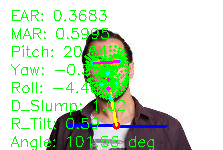

Preview saved: ./Outputs\previews\Awake__100_jpg.rf.c81efb146d155327305f5470bfc60b6d.jpg


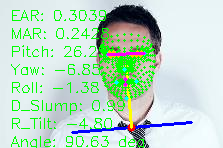

Preview saved: ./Outputs\previews\Awake__101_jpg.rf.84809ab52d0cf4fe45f1871a956b7a56.jpg


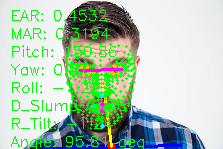

Preview saved: ./Outputs\previews\Awake__102_jpg.rf.7763987c1b6d85808492937dc241ead9.jpg


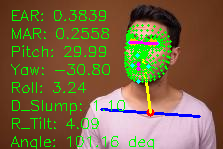

Preview saved: ./Outputs\previews\Awake__103_jpg.rf.ca8b1ec219295b7b3eb32602e47ca3df.jpg


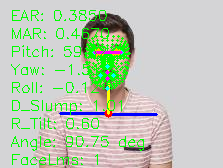

Preview saved: ./Outputs\previews\Awake__104_jpg.rf.aa95952865b538c389ba71dc8040a573.jpg
Processing folder 'Passed_out' - total images: 237 (showing up to 100):
 - ./Datasets_train\Passed_out\1000_jpg.rf.1c64ec6d81d97108ef4a86d536b458e6.jpg
 - ./Datasets_train\Passed_out\1019_jpg.rf.381b09f4f440ae6b8e0584ef84e875aa.jpg
 - ./Datasets_train\Passed_out\1020_jpg.rf.32d2b12db3f52b5513e5debeaef23b40.jpg
 - ./Datasets_train\Passed_out\1037_jpg.rf.1c5bfb4cc89aa409207122f4a4cbc3ca.jpg
 - ./Datasets_train\Passed_out\1039_jpg.rf.d777aee1cfd72b64ae704e0d20b54f8b.jpg
 - ./Datasets_train\Passed_out\1040_jpg.rf.48d63110f00fc864fc44b00e29a3806a.jpg
 - ./Datasets_train\Passed_out\1058_jpg.rf.c24dbc54146567afc46f90e92d6d01da.jpg
 - ./Datasets_train\Passed_out\1060_jpg.rf.4f2217a969d09f89a1236324a46ea65e.jpg
 - ./Datasets_train\Passed_out\1078_jpg.rf.2f3504f012aefcc20be2db9a836b2263.jpg
 - ./Datasets_train\Passed_out\1079_jpg.rf.6af0f09d9162e8e3705a8da3e756be35.jpg
 - ./Datasets_train\Passed_out\1099_jpg

,EAR,MAR,PITCH,YAW,ROLL,D_SLUMP,R_TILT,EYE_CL,FACIAL_DISPLAYED,POSE_DISPLAYED,SHOULDER_NOSE_ANGLE,SHOULDER_NOSE_COS,Label,File_name
0,0.3683,0.5995,20.6413,-0.3579,-4.4268,1.0248,0.5907,0.0697,1.0,1.0,101.559693,-0.200389,0,./Datasets_train\Awake\100_jpg.rf.c81efb146d15...
1,0.3039,0.2428,26.2483,-6.8454,-1.3777,0.9924,-4.8035,0.0626,1.0,1.0,90.632666,-0.011042,0,./Datasets_train\Awake\101_jpg.rf.84809ab52d0c...
2,0.4532,0.3194,130.8591,0.5722,-1.2155,0.7641,-1.2364,0.0929,1.0,1.0,95.806351,-0.101167,0,./Datasets_train\Awake\102_jpg.rf.7763987c1b6d...
3,0.3839,0.2558,29.9901,-30.8024,3.2415,1.0965,4.0856,0.0741,1.0,1.0,101.158618,-0.193526,0,./Datasets_train\Awake\103_jpg.rf.ca8b1ec21929...
4,0.3850,0.4670,59.6160,-1.5095,-0.1199,1.0106,0.5968,0.0714,1.0,1.0,90.753568,-0.013152,0,./Datasets_train\Awake\104_jpg.rf.aa95952865b5...


In [ ]:
# === Run full data collection and export CSV ===
import os
import cv2
import pandas as pd
import traceback
from IPython.display import display, Image as IPyImage

os.makedirs(OUTPUT_DIR, exist_ok=True)
face_model_path = os.path.join('model', 'face_landmarker.task')
pose_model_path = os.path.join('model', 'pose_landmarker_full.task')

# Normalize model paths for Windows to avoid MediaPipe join issue
import pathlib
face_model_path_abs = os.path.abspath(face_model_path)
pose_model_path_abs = os.path.abspath(pose_model_path)
face_model_path_posix = pathlib.Path(face_model_path_abs).as_posix()
pose_model_path_posix = pathlib.Path(pose_model_path_abs).as_posix()

# Quick display settings: show a small preview (log + image) for the first N processed images
DISPLAY_PREVIEWS = True
PREVIEW_LIMIT = 5
_displayed_previews = 0
# If True, save and display an annotated preview for processed images, but we will cap saves per-folder
# Disable bulk previewing in the notebook to avoid flooding VSCode UI / memory
SHOW_ALL_PREVIEWS = False

# Where annotated previews will be written for manual inspection/deletion
PREVIEW_DIR = os.path.join(OUTPUT_DIR, 'previews')
os.makedirs(PREVIEW_DIR, exist_ok=True)

# Sanity: print absolute paths and test readable
print('Face model expected at (orig):', os.path.abspath(face_model_path))
print('Pose model expected at (orig):', os.path.abspath(pose_model_path))
print('Face model posix:', face_model_path_posix)
print('Pose model posix:', pose_model_path_posix)
for p in (face_model_path_abs, pose_model_path_abs):
    try:
        with open(p, 'rb') as fh:
            head = fh.read(16)
        print(f'Readable: {p} (first bytes: {len(head)} bytes)')
    except Exception as e:
        print(f'Failed to open {p}:', e)

if not (os.path.exists(face_model_path_abs) and os.path.exists(pose_model_path_abs)):
    print('MediaPipe model files missing. Expected:', face_model_path_abs, 'and', pose_model_path_abs)
    print('Place the .task files in the ./model/ folder and re-run this cell.')
else:
    try:
        # Use POSIX-style absolute paths for MediaPipe on Windows to prevent incorrect joins
        base_options_face = python.BaseOptions(model_asset_path=face_model_path_posix)
        face_options = vision.FaceLandmarkerOptions(base_options=base_options_face, running_mode=vision.RunningMode.IMAGE)
        face_landmarker = vision.FaceLandmarker.create_from_options(face_options)

        base_options_pose = python.BaseOptions(model_asset_path=pose_model_path_posix)
        pose_options = vision.PoseLandmarkerOptions(base_options=base_options_pose, running_mode=vision.RunningMode.IMAGE)
        pose_landmarker = vision.PoseLandmarker.create_from_options(pose_options)
    except Exception as e:
        print('Failed to initialize mediapipe landmarkers:')
        traceback.print_exc()
        raise

    data_rows = []
    # Build label map with explicit desired mapping to ensure folder->label consistency
    # Desired mapping: 0=Awake, 1=Sleeping, 2=Yawning, 3=Passed_out
    desired_map = {'Awake': 0, 'Sleep': 1, 'Yawning': 2, 'Passed_out': 3}
    label_map = {}
    # Assign desired labels if the expected folders exist
    for name, idx in desired_map.items():
        path = os.path.join(DATA_ROOT, name)
        if os.path.isdir(path):
            label_map[name] = idx
        else:
            # If a desired folder is missing, skip but keep other mappings stable
            pass
    # Add any other folders present in DATA_ROOT, assigning unique labels after the desired indices
    existing_dirs = [d for d in sorted(os.listdir(DATA_ROOT)) if os.path.isdir(os.path.join(DATA_ROOT, d))]
    next_label = max(label_map.values()) + 1 if label_map else 0
    for d in existing_dirs:
        if d in label_map:
            continue
        label_map[d] = next_label
        next_label += 1

    print('Label mapping:', label_map)

    # Iterate through labeled directories
    for label in sorted(os.listdir(DATA_ROOT)):
        dir_path = os.path.join(DATA_ROOT, label)
        if not os.path.isdir(dir_path):
            continue

        # collect images in this folder and show up to 100 paths in the log
        all_imgs = [os.path.join(dir_path, f) for f in sorted(os.listdir(dir_path)) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        print(f"Processing folder '{label}' - total images: {len(all_imgs)} (showing up to 100):")
        for p in all_imgs[:100]:
            print(' -', p)

        # Determine how many annotated previews to save for this folder to avoid disk/UI overload.
        # Policy: save at most 5 previews per folder (safe for laptops/VSCode).
        folder_preview_limit = min(5, len(all_imgs))
        saved_previews_in_folder = 0

        for fpath in all_imgs:
            fname = os.path.basename(fpath)
            img = cv2.imread(fpath)
            if img is None:
                print('Failed to read image', fpath)
                continue
            features, is_reliable = extract_features(img, face_landmarker, pose_landmarker)
            if not is_reliable:
                # still create a small annotated preview to inspect missing detections if requested
                face_lms = None
                pose_lms = None
            else:
                # Also compute shoulder-nose angle for diagnostics and export
                try:
                    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    mp_img = MpImage(image_format=mp.ImageFormat.SRGB, data=rgb)
                    fres = face_landmarker.detect(mp_img)
                    pres = pose_landmarker.detect(mp_img)
                    fl = getattr(fres, 'face_landmarks', None)
                    pl = getattr(pres, 'pose_landmarks', None)
                    face_lms = fl[0] if (fl and len(fl) > 0) else None
                    pose_lms = pl[0] if (pl and len(pl) > 0) else None
                    angle_deg, cos_val = compute_shoulder_nose_angle(pose_lms, face_lms, img.shape[1], img.shape[0])
                except Exception:
                    angle_deg, cos_val = DUMMY_VALUE, DUMMY_VALUE
                    face_lms = None
                    pose_lms = None

            row = {
                'EAR': features[0], 'MAR': features[1], 'PITCH': features[2],
                'YAW': features[3], 'ROLL': features[4], 'D_SLUMP': features[5],
                'R_TILT': features[6], 'EYE_CL': features[7],
                'FACIAL_DISPLAYED': features[8], 'POSE_DISPLAYED': features[9],
                'SHOULDER_NOSE_ANGLE': angle_deg, 'SHOULDER_NOSE_COS': cos_val,
                'Label': label_map.get(label, DUMMY_VALUE), 'File_name': fpath,
            }
            data_rows.append(row)

            # Build annotated overlay for inspection (facemesh, key landmarks, shoulders)
            try:
                overlay = img.copy()
                h, w = img.shape[:2]

                # draw pose landmarks (shoulders and nose->midpoint)
                if pose_lms is not None:
                    try:
                        p_n = pose_lms[0]
                        p_l = pose_lms[11]
                        p_r = pose_lms[12]
                        x_n, y_n = int(p_n.x * w), int(p_n.y * h)
                        x_l, y_l = int(p_l.x * w), int(p_l.y * h)
                        x_r, y_r = int(p_r.x * w), int(p_r.y * h)
                        mx, my = int((x_l + x_r) / 2), int((y_l + y_r) / 2)
                        cv2.line(overlay, (x_l, y_l), (x_r, y_r), (255, 0, 0), 2)
                        cv2.circle(overlay, (mx, my), 4, (0, 0, 255), -1)
                        cv2.line(overlay, (x_n, y_n), (mx, my), (0, 255, 255), 2)
                    except Exception:
                        pass

                # draw face landmarks (small dots), highlight eyes/mouth/head-pose indices
                if face_lms is not None:
                    try:
                        for i, lm in enumerate(face_lms):
                            cx, cy = int(float(lm.x) * w), int(float(lm.y) * h)
                            cv2.circle(overlay, (cx, cy), 1, (0, 255, 0), -1)
                        # highlight selected groups
                        for idx in LEFT_EYE_INDICES:
                            lm = face_lms[idx]
                            cx, cy = int(float(lm.x) * w), int(float(lm.y) * h)
                            cv2.circle(overlay, (cx, cy), 2, (0, 191, 255), -1)
                        for idx in RIGHT_EYE_INDICES:
                            lm = face_lms[idx]
                            cx, cy = int(float(lm.x) * w), int(float(lm.y) * h)
                            cv2.circle(overlay, (cx, cy), 2, (0, 191, 255), -1)
                        for idx in MOUTH_INDICES:
                            lm = face_lms[idx]
                            cx, cy = int(float(lm.x) * w), int(float(lm.y) * h)
                            cv2.circle(overlay, (cx, cy), 2, (255, 0, 255), -1)
                        for idx in HEAD_POSE_INDICES:
                            if idx < len(face_lms):
                                lm = face_lms[idx]
                                cx, cy = int(float(lm.x) * w), int(float(lm.y) * h)
                                cv2.circle(overlay, (cx, cy), 2, (255, 255, 0), -1)

                        # Draw an eye-to-eye line to visualize roll explicitly
                        try:
                            l_e = face_lms[33]
                            r_e = face_lms[263]
                            lx, ly = int(float(l_e.x) * w), int(float(l_e.y) * h)
                            rx, ry = int(float(r_e.x) * w), int(float(r_e.y) * h)
                            cv2.line(overlay, (lx, ly), (rx, ry), (255, 0, 255), 2)
                        except Exception:
                            pass

                    except Exception:
                        pass

                # annotate with computed stats (include pitch/yaw/roll)
                txts = [
                    f'EAR: {features[0]:.4f}' if features[0] != DUMMY_VALUE else 'EAR: DUMMY',
                    f'MAR: {features[1]:.4f}' if features[1] != DUMMY_VALUE else 'MAR: DUMMY',
                    f'Pitch: {features[2]:.2f}' if features[2] != DUMMY_VALUE else 'Pitch: DUMMY',
                    f'Yaw: {features[3]:.2f}' if features[3] != DUMMY_VALUE else 'Yaw: DUMMY',
                    f'Roll: {features[4]:.2f}' if features[4] != DUMMY_VALUE else 'Roll: DUMMY',
                    f'D_Slump: {features[5]:.2f}' if features[5] != DUMMY_VALUE else 'D_Slump: DUMMY',
                    f'R_Tilt: {features[6]:.2f}' if features[6] != DUMMY_VALUE else 'R_Tilt: DUMMY',
                    f'Angle: {angle_deg:.2f} deg' if angle_deg != DUMMY_VALUE else 'Angle: DUMMY',
                    f'FaceLms: {1 if face_lms is not None else 0}',
                    f'PoseLms: {1 if pose_lms is not None else 0}'
                ]
                for i, t in enumerate(txts):
                    cv2.putText(overlay, t, (10, 20 + i*18), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

                # Save annotated preview to disk for manual review / deletion
                preview_name = f"{label}__{fname}"
                preview_path = os.path.join(PREVIEW_DIR, preview_name)
                # Only write up to the per-folder limit to prevent excessive disk usage
                if saved_previews_in_folder < folder_preview_limit:
                    try:
                        # Resize preview to a reasonable size to reduce memory/UI load
                        max_dim = 800
                        oh, ow = overlay.shape[:2]
                        if max(oh, ow) > max_dim:
                            scale = max_dim / float(max(oh, ow))
                            small_preview = cv2.resize(overlay, (int(ow*scale), int(oh*scale)), interpolation=cv2.INTER_AREA)
                        else:
                            small_preview = overlay
                        cv2.imwrite(preview_path, small_preview)
                        saved_previews_in_folder += 1
                    except Exception as e:
                        print('Failed to write preview', preview_path, ':', e)

                # Avoid displaying every preview inline; show only the first few overall (DISPLAY_PREVIEWS controls)
                if DISPLAY_PREVIEWS and _displayed_previews < PREVIEW_LIMIT:
                    try:
                        _, buf = cv2.imencode('.png', small_preview)
                        display(IPyImage(data=buf.tobytes()))
                        print('Preview saved:', preview_path)
                        _displayed_previews += 1
                    except Exception as e:
                        print('Inline preview failed for', fpath, ':', e)

            except Exception as e:
                print('Preview render failed for', fpath, ':', e)

    df_out = pd.DataFrame(data_rows)
    if not df_out.empty:
        # round numeric columns 0:8
        df_out.iloc[:, 0:8] = df_out.iloc[:, 0:8].round(4)
        df_out.to_csv(OUTPUT_CSV, index=False)
        print('Wrote', OUTPUT_CSV, 'rows:', len(df_out))
        display(df_out.head())
    else:
        print('No reliable feature rows extracted. CSV not written.')


In [ ]:
# --- Notebook: Model path normalization & mediapipe instantiation checker ---
# Purpose: try a few path formats (abs, posix, file://) to avoid the Windows path join bug
import os, traceback, pathlib, sys
print('Notebook Python executable:', sys.executable)

def normalize_model_path(p):
    p_abs = os.path.abspath(p)
    p_posix = pathlib.Path(p_abs).as_posix()
    return p_abs, p_posix

face_model = os.path.join('model', 'face_landmarker.task')
pose_model = os.path.join('model', 'pose_landmarker_full.task')

for original in (face_model, pose_model):
    abs_path, posix_path = normalize_model_path(original)
    print('---')
    print('Original:', original)
    print(' abs_path:', abs_path)
    print(' posix_path:', posix_path)
    tried = []
    for attempt in (abs_path, posix_path, 'file://' + abs_path):
        tried.append(attempt)
        try:
            print(' Trying path:', attempt)
            base_options = python.BaseOptions(model_asset_path=attempt)
            if original.endswith('face_landmarker.task'):
                opts = vision.FaceLandmarkerOptions(base_options=base_options, running_mode=vision.RunningMode.IMAGE)
                lm = vision.FaceLandmarker.create_from_options(opts)
                lm = None
            else:
                opts = vision.PoseLandmarkerOptions(base_options=base_options, running_mode=vision.RunningMode.IMAGE)
                lm = vision.PoseLandmarker.create_from_options(opts)
                lm = None
            print('  -> instantiate succeeded for', original)
            break
        except Exception as e:
            print('  -> instantiate failed:', type(e).__name__, str(e))
            tb = traceback.format_exc()
            # show last traceback line for brevity
            print('   traceback tail:', tb.splitlines()[-1])
    print(' Tried formats:', tried)

# Guidance: If you see the path prefixed by your site-packages directory (like '.../site-packages/c:\\...'),
# the POSIX-style path (as_posix) or the 'file://' prefix usually prevents MediaPipe from joining paths incorrectly on Windows.


Notebook Python executable: c:\Users\Admin\anaconda3\envs\Drowsiness_detection\python.exe
---
Original: model\face_landmarker.task
 abs_path: c:\Code\Year_2\AI_Drowsiness_Detection\model\face_landmarker.task
 posix_path: c:/Code/Year_2/AI_Drowsiness_Detection/model/face_landmarker.task
 Trying path: c:\Code\Year_2\AI_Drowsiness_Detection\model\face_landmarker.task
  -> instantiate succeeded for model\face_landmarker.task
 Tried formats: ['c:\\Code\\Year_2\\AI_Drowsiness_Detection\\model\\face_landmarker.task']
---
Original: model\pose_landmarker_full.task
 abs_path: c:\Code\Year_2\AI_Drowsiness_Detection\model\pose_landmarker_full.task
 posix_path: c:/Code/Year_2/AI_Drowsiness_Detection/model/pose_landmarker_full.task
 Trying path: c:\Code\Year_2\AI_Drowsiness_Detection\model\pose_landmarker_full.task
  -> instantiate succeeded for model\pose_landmarker_full.task
 Tried formats: ['c:\\Code\\Year_2\\AI_Drowsiness_Detection\\model\\pose_landmarker_full.task']


In [ ]:
df = pd.read_csv('./Outputs/training-feature.csv',header=0)
df

,EAR,MAR,PITCH,YAW,ROLL,D_SLUMP,R_TILT,EYE_CL,FACIAL_DISPLAYED,POSE_DISPLAYED,SHOULDER_NOSE_ANGLE,SHOULDER_NOSE_COS,Label,File_name
0,0.3683,0.5995,20.6413,-0.3579,-4.4268,1.0248,0.5907,0.0697,1.0,1.0,101.559693,-0.200389,0,./Datasets_train\Awake\100_jpg.rf.c81efb146d15...
1,0.3039,0.2428,26.2483,-6.8454,-1.3777,0.9924,-4.8035,0.0626,1.0,1.0,90.632666,-0.011042,0,./Datasets_train\Awake\101_jpg.rf.84809ab52d0c...
2,0.4532,0.3194,130.8591,0.5722,-1.2155,0.7641,-1.2364,0.0929,1.0,1.0,95.806351,-0.101167,0,./Datasets_train\Awake\102_jpg.rf.7763987c1b6d...
3,0.3839,0.2558,29.9901,-30.8024,3.2415,1.0965,4.0856,0.0741,1.0,1.0,101.158618,-0.193526,0,./Datasets_train\Awake\103_jpg.rf.ca8b1ec21929...
4,0.3850,0.4670,59.6160,-1.5095,-0.1199,1.0106,0.5968,0.0714,1.0,1.0,90.753568,-0.013152,0,./Datasets_train\Awake\104_jpg.rf.aa95952865b5...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,0.5407,1.3963,46.3603,27.0817,-1.8564,0.6444,-11.1951,0.0933,1.0,1.0,56.069281,0.558190,2,./Datasets_train\Yawning\98_jpg.rf.53e253f924f...
2065,0.5027,1.2889,52.5522,27.6949,-3.5483,0.6542,-8.9040,0.0858,1.0,1.0,59.904457,0.501443,2,./Datasets_train\Yawning\99_jpg.rf.6ebf77c0923...
2066,0.5027,1.2889,52.5522,27.6949,-3.5483,0.6542,-8.9040,0.0858,1.0,1.0,59.904457,0.501443,2,./Datasets_train\Yawning\99_jpg.rf.e36044df54f...
2067,0.3074,0.7548,51.6317,-6.8744,6.3448,0.3807,-4.6281,0.0621,1.0,1.0,71.103051,0.323867,2,./Datasets_train\Yawning\9_jpg.rf.0377dc31d5f2...


In [ ]:
# Specify the path to the individual image you want to check
image_path = './Datasets_train/Yawning/186_jpg.rf.74a7612a2a1b87a617e984d51bccca57.jpg'  # Replace with your image path

# Load the image
img = cv2.imread(image_path)
if img is None:
    print(f"Failed to load image from {image_path}")
else:
    print(f"Successfully loaded image from {image_path}")
    
    # Extract features using the existing extract_features function
    features, is_reliable = extract_features(img, face_landmarker, pose_landmarker)
    
    print("Is reliable:", is_reliable)
    print("Features array:", features)
    
    # Feature names for clarity
    feature_names = ['EAR', 'MAR', 'PITCH', 'YAW', 'ROLL', 'D_SLUMP', 'R_TILT', 'EYE_CL', 'FACIAL_DISPLAYED', 'POSE_DISPLAYED']
    
    # Check each feature and explain if it's dummy
    for name, val in zip(feature_names, features):
        if val == DUMMY_VALUE:
            if name in ['EAR', 'MAR', 'PITCH', 'YAW', 'ROLL', 'EYE_CL']:
                reason = "Face not detected or facial landmark extraction failed."
            elif name in ['D_SLUMP', 'R_TILT']:
                reason = "Pose not detected or pose landmark extraction failed."
            elif name == 'FACIAL_DISPLAYED':
                reason = "No face landmarks detected."
            elif name == 'POSE_DISPLAYED':
                reason = "No pose landmarks detected."
            else:
                reason = "Unknown reason."
            print(f"{name}: {val} (DUMMY - {reason})")
        else:
            print(f"{name}: {val}")
    
    # Additional diagnostics: check if face and pose were detected
    h, w, c = img.shape
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mp_image = MpImage(image_format=mp.ImageFormat.SRGB, data=rgb_image)
    
    face_result = face_landmarker.detect(mp_image)
    pose_result = pose_landmarker.detect(mp_image)
    
    face_landmarks_list = getattr(face_result, 'face_landmarks', None)
    pose_landmarks_list = getattr(pose_result, 'pose_landmarks', None)
    
    face_disp = 1.0 if (face_landmarks_list and len(face_landmarks_list) > 0) else 0.0
    pose_disp = 0.0
    if pose_landmarks_list:
        try:
            first_pose = pose_landmarks_list[0]
            npoints = len(first_pose)
        except Exception:
            try:
                npoints = len(pose_landmarks_list)
            except Exception:
                npoints = 0
        if npoints >= 13:
            pose_disp = 1.0
    
    print(f"Face detected: {face_disp == 1.0} (face_disp={face_disp})")
    print(f"Pose detected: {pose_disp == 1.0} (pose_disp={pose_disp})")
    
    # If you want to visualize, you can add overlay drawing here similar to CELL INDEX: 9

Successfully loaded image from ./Datasets_train/Yawning/186_jpg.rf.74a7612a2a1b87a617e984d51bccca57.jpg
Is reliable: True
Features array: [-999.     -999.     -999.     -999.     -999.     -999.       -9.0257
 -999.        0.        1.    ]
EAR: -999.0 (DUMMY - Face not detected or facial landmark extraction failed.)
MAR: -999.0 (DUMMY - Face not detected or facial landmark extraction failed.)
PITCH: -999.0 (DUMMY - Face not detected or facial landmark extraction failed.)
YAW: -999.0 (DUMMY - Face not detected or facial landmark extraction failed.)
ROLL: -999.0 (DUMMY - Face not detected or facial landmark extraction failed.)
D_SLUMP: -999.0 (DUMMY - Pose not detected or pose landmark extraction failed.)
R_TILT: -9.0257
EYE_CL: -999.0 (DUMMY - Face not detected or facial landmark extraction failed.)
FACIAL_DISPLAYED: 0.0
POSE_DISPLAYED: 1.0
Face detected: False (face_disp=0.0)
Pose detected: True (pose_disp=1.0)


In [6]:
# Debug cell: draw selected landmarks on a user-specified image (or auto-sample)
import os
import cv2
from IPython.display import display, Image as IPyImage

# Ask the user for a single image path; leave empty to auto-sample from DATA_ROOT
image_path = input('Enter image path (leave empty to auto-sample): ').strip()
sample_paths = []
if image_path:
    if os.path.exists(image_path):
        sample_paths = [image_path]
    else:
        print('Path not found:', image_path)
        raise SystemExit('Invalid image path')
else:
    # collect sample images from DATA_ROOT (up to 5)
    for d in sorted(os.listdir(DATA_ROOT)):
        dd = os.path.join(DATA_ROOT, d)
        if not os.path.isdir(dd):
            continue
        for f in sorted(os.listdir(dd)):
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                sample_paths.append(os.path.join(dd, f))
            if len(sample_paths) >= 5:
                break
        if len(sample_paths) >= 5:
            break

print('Sample images:', len(sample_paths))
if not sample_paths:
    raise SystemExit('No sample images found in DATA_ROOT')

os.makedirs(os.path.join(OUTPUT_DIR, 'previews'), exist_ok=True)

# Prefer the lightweight mediapipe task-based landmarkers if available in notebook; otherwise fallback to mp.solutions
use_task_landmarkers = ('face_landmarker' in globals() and 'pose_landmarker' in globals() and face_landmarker is not None and pose_landmarker is not None)
if not use_task_landmarkers:
    mp_face_mesh = mp.solutions.face_mesh
    mp_pose = mp.solutions.pose

for p in sample_paths:
    img = cv2.imread(p)
    if img is None:
        print('Failed to read', p)
        continue
    h, w = img.shape[:2]
    overlay = img.copy()

    face_detected = False
    pose_detected = False
    face_lms = None
    pose_lms = None

    try:
        if use_task_landmarkers:
            # Use the pre-initialized mediapipe task-based landmarkers
            rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mp_img = MpImage(image_format=mp.ImageFormat.SRGB, data=rgb)
            fres = face_landmarker.detect(mp_img)
            pres = pose_landmarker.detect(mp_img)
            fl = getattr(fres, 'face_landmarks', None)
            pl = getattr(pres, 'pose_landmarks', None)
            if fl and len(fl) > 0:
                face_detected = True
                face_lms = fl[0]
            if pl and len(pl) > 0:
                pose_detected = True
                pose_lms = pl[0]
        else:
            # fallback to mp.solutions for quick debugging (no .task files required)
            rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            with mp_face_mesh.FaceMesh(refine_landmarks=True, max_num_faces=1) as fm, mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pm:
                fres = fm.process(rgb)
                pres = pm.process(rgb)
                if getattr(fres, 'multi_face_landmarks', None):
                    face_detected = True
                    face_lms = fres.multi_face_landmarks[0].landmark
                if getattr(pres, 'pose_landmarks', None):
                    pose_detected = True
                    pose_lms = pres.pose_landmarks.landmark
    except Exception as e:
        print('Landmark detection failed for', p, ':', e)

    # Draw simple landmarks/diagnostics similar to collection preview code
    try:
        if pose_detected and pose_lms is not None:
            try:
                p_n = pose_lms[0]
                p_l = pose_lms[LEFT_SHOULDER_INDEX]
                p_r = pose_lms[RIGHT_SHOULDER_INDEX]
                x_n, y_n = int(p_n.x * w), int(p_n.y * h)
                x_l, y_l = int(p_l.x * w), int(p_l.y * h)
                x_r, y_r = int(p_r.x * w), int(p_r.y * h)
                mx, my = int((x_l + x_r) / 2), int((y_l + y_r) / 2)
                cv2.line(overlay, (x_l, y_l), (x_r, y_r), (255, 0, 0), 2)
                cv2.circle(overlay, (mx, my), 4, (0, 0, 255), -1)
                cv2.line(overlay, (x_n, y_n), (mx, my), (0, 255, 255), 2)
            except Exception:
                pass

        if face_detected and face_lms is not None:
            try:
                sel_face_indices = [33, 263, 152, 10, 13, 61, 291]
                for idx in sel_face_indices:
                    if idx < len(face_lms):
                        lm = face_lms[idx]
                        cx, cy = int(float(lm.x) * w), int(float(lm.y) * h)
                        cv2.circle(overlay, (cx, cy), 3, (0,255,0), -1)
                # eye-eye line for roll visualization
                try:
                    l_e = face_lms[33]
                    r_e = face_lms[263]
                    lx, ly = int(float(l_e.x) * w), int(float(l_e.y) * h)
                    rx, ry = int(float(r_e.x) * w), int(float(r_e.y) * h)
                    cv2.line(overlay, (lx, ly), (rx, ry), (255, 0, 255), 2)
                except Exception:
                    pass
            except Exception:
                pass

        # compute and annotate head/pose-derived values when possible
        try:
            if face_detected:
                (yaw, pitch, roll), _ = get_head_pose(face_lms, w, h, overlay)
            else:
                yaw = pitch = roll = DUMMY_VALUE
        except Exception as e:
            yaw = pitch = roll = DUMMY_VALUE
            print('get_head_pose error:', e)

        try:
            if pose_detected:
                d_slump, r_tilt = calculate_slump_features(face_lms, pose_lms, w, h, overlay)
            else:
                d_slump = r_tilt = DUMMY_VALUE
        except Exception as e:
            d_slump = r_tilt = DUMMY_VALUE
            print('calculate_slump_features error:', e)

        texts = [
            f'Face: {int(face_detected)}',
            f'Pose: {int(pose_detected)}',
            f'Pitch: {pitch:.2f}' if pitch != DUMMY_VALUE else 'Pitch: DUMMY',
            f'Yaw: {yaw:.2f}' if yaw != DUMMY_VALUE else 'Yaw: DUMMY',
            f'Roll: {roll:.2f}' if roll != DUMMY_VALUE else 'Roll: DUMMY',
            f'D_Slump: {d_slump:.3f}' if d_slump != DUMMY_VALUE else 'D_Slump: DUMMY',
            f'R_Tilt: {r_tilt:.2f}' if r_tilt != DUMMY_VALUE else 'R_Tilt: DUMMY',
        ]
        for i, t in enumerate(texts):
            cv2.putText(overlay, t, (10, 30 + i*22), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

        out_path = os.path.join(OUTPUT_DIR, 'previews', 'annot_' + os.path.basename(p))
        try:
            cv2.imwrite(out_path, overlay)
            print('Wrote:', out_path)
        except Exception as e:
            print('Failed to write', out_path, ':', e)

        # show inline (resized to reasonable size)
        try:
            max_dim = 1000
            oh, ow = overlay.shape[:2]
            if max(oh, ow) > max_dim:
                scale = max_dim / float(max(oh, ow))
                small_preview = cv2.resize(overlay, (int(ow*scale), int(oh*scale)), interpolation=cv2.INTER_AREA)
            else:
                small_preview = overlay
            _, buf = cv2.imencode('.png', small_preview)
            display(IPyImage(data=buf.tobytes()))
        except Exception as e:
            print('Inline display failed for', p, ':', e)

    except Exception as e:
        print('Overlay rendering failed for', p, ':', e)

print('Done. Check Outputs/previews for annotated images.')


Sample images: 1


NameError: name 'OUTPUT_DIR' is not defined